In [1]:
import pandas as pd
import numpy as np
import os
import pyaging as pya
import pickle
import scanpy as sc
import seaborn as sns
from scipy.stats import pearsonr
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec # Import gridspec
import GEOparse
from scipy import stats
from statsmodels.stats.multitest import multipletests

os.chdir('/mnt/f/MetaAnalysisMethylation')


In [2]:
tableDir = 'output/tables'
figureDir = 'output/figures'

sampleSet = 'GSE203332'

# functions

In [3]:
def pairs_statistics(data, condition_col, change_col, group1 = 'Ctrl', group2='PD'):
    from scipy import stats # Import stats module from scipy
    group1_changes = data[data[condition_col] == group1][change_col].dropna()
    group2_changes = data[data[condition_col] == group2][change_col].dropna()
    
    print(f"Number of Ctrl donors: {len(group1_changes)}")
    print(f"Number of PD donors:   {len(group2_changes)}")
    
    if len(group1_changes) < 2 or len(group2_changes) < 2:
        print("\nCannot perform test: Need at least 2 data points per group.")
    else:
        # 2. Check Assumptions (Optional but recommended)
        print("\nChecking assumptions (results printed for info):")
        # Normality Check (Shapiro-Wilk test)
        shapiro_group1_stat, shapiro_group1_p = stats.shapiro(group1_changes)
        shapiro_group2_stat, shapiro_group2_p = stats.shapiro(group2_changes)
        print(f"  Normality (Shapiro-Wilk): Ctrl p-value={shapiro_group1_p:.3f}, PD p-value={shapiro_group2_p:.3f}")
        is_group1_normal = shapiro_group1_p > 0.05
        is_group2_normal = shapiro_group2_p > 0.05
        if not is_group1_normal or not is_group2_normal:
            print("  Note: At least one group may not be normally distributed (p <= 0.05).")
    
        # Equal Variance Check (Levene's test)
        levene_stat, levene_p = stats.levene(group1_changes, group2_changes)
        print(f"  Equal Variance (Levene): p-value={levene_p:.3f}")
        has_equal_variance = levene_p > 0.05
        if not has_equal_variance:
            print("  Note: Variances may not be equal (p <= 0.05).")
    
        # 3. Perform Statistical Test
    
        # --- Option A: Mann-Whitney U Test (Non-parametric, often preferred) ---
        print("\nPerforming Mann-Whitney U test (non-parametric)...")
        # alternative='two-sided' tests if distributions are different
        # alternative='less' tests if Ctrl distribution is stochastically less than PD
        # alternative='greater' tests if Ctrl distribution is stochastically greater than PD
        try:
            u_statistic, p_value_mw = stats.mannwhitneyu(group1_changes, group2_changes, alternative='two-sided')
            print(f"  Mann-Whitney U statistic: {u_statistic:.3f}")
            print(f"  P-value: {p_value_mw:.4f}")
    
            # Interpretation
            alpha = 0.05
            if p_value_mw < alpha:
                print(f"  Result: Significant difference found between Ctrl and PD distributions (p < {alpha}).")
            else:
                print(f"  Result: No significant difference found between Ctrl and PD distributions (p >= {alpha}).")
        except ValueError as e:
             print(f"  Could not perform Mann-Whitney U test: {e}")
    
    
        # --- Option B: Independent Two-Sample T-test (Parametric) ---
        # Choose equal_var based on Levene's test result
        equal_var_assumption = has_equal_variance
        test_type = "Student's t-test" if equal_var_assumption else "Welch's t-test"
        print(f"\nPerforming Independent Two-Sample T-test ({test_type}, parametric)...")
        if not is_group1_normal or not is_group2_normal:
             print("  Warning: Data may not be normally distributed; interpret t-test results with caution.")
    
        try:
            t_statistic, p_value_ttest = stats.ttest_ind(group1_changes, group2_changes, equal_var=equal_var_assumption, nan_policy='omit')
            print(f"  T-statistic: {t_statistic:.3f}")
            print(f"  P-value: {p_value_ttest:.4f}")
    
            # Interpretation
            alpha = 0.05
            if p_value_ttest < alpha:
                print(f"  Result: Significant difference found between Ctrl and PD means (p < {alpha}).")
            else:
                print(f"  Result: No significant difference found between Ctrl and PD means (p >= {alpha}).")
        except Exception as e:
            print(f"  Could not perform t-test: {e}")
    
    
        print("\n--- Interpretation Guidance ---")
        print("Choose the test result based on assumptions:")
        print("- If data is NOT normally distributed (especially with small N), prefer Mann-Whitney U.")
        print("- If data IS normally distributed:")
        print("  - Use T-test result.")
        print("  - If variances were unequal (Levene p <= 0.05), Welch's t-test (equal_var=False) was used.")
        print("  - If variances were equal (Levene p > 0.05), Student's t-test (equal_var=True) was used.")
        print(f"A p-value below alpha (typically 0.05) indicates a statistically significant difference.")


# Load datasets

In [5]:
data = pd.read_csv(os.path.join('GSE195834', 'GSE195834_2-PD-processed.csv.gz'), sep=',', index_col=0)


In [6]:
data[1:10]

,Sample_14901,Sample_14901_Detection_Pval,Sample_14902,Sample_14902_Detection_Pval,Sample_14903,Sample_14903_Detection_Pval,Sample_14904,Sample_14904_Detection_Pval,Sample_14905,Sample_14905_Detection_Pval,...,Sample_14979,Sample_14979_Detection_Pval,Sample_14980,Sample_14980_Detection_Pval,Sample_14981,Sample_14981_Detection_Pval,Sample_14982,Sample_14982_Detection_Pval,Sample_14983,Sample_14983_Detection_Pval
ID_REF,,,,,,,,,,,,,,,,,,,,,
cg09835024,0.029747,0.000000e+00,0.036241,0.000000e+00,0.034418,0.000000e+00,0.026570,0.000000e+00,0.021975,0.000000e+00,...,0.016561,0.000000e+00,0.021211,0.000000e+00,0.034529,0.000000e+00,0.030047,0.000000e+00,0.026903,0.000000e+00
cg14361672,0.928005,0.000000e+00,0.936565,0.000000e+00,0.958633,0.000000e+00,0.959924,0.000000e+00,0.944594,0.000000e+00,...,0.947766,0.000000e+00,0.974423,0.000000e+00,0.927955,0.000000e+00,0.954797,0.000000e+00,0.960336,0.000000e+00
cg01763666,0.957944,0.000000e+00,0.957048,0.000000e+00,0.959468,0.000000e+00,0.943942,1.840000e-160,0.928684,0.000000e+00,...,0.952855,0.000000e+00,0.916150,2.310000e-108,0.921511,0.000000e+00,0.955384,0.000000e+00,0.962417,0.000000e+00
cg12950382,0.892283,4.380000e-96,0.836956,9.450000e-40,0.839780,2.120000e-30,0.910867,2.650000e-64,0.839037,3.460000e-55,...,0.839216,3.840000e-53,0.885991,1.240000e-117,0.912402,7.600000e-121,0.875177,1.340000e-66,0.763473,6.970000e-57
cg02115394,0.029712,0.000000e+00,0.027296,0.000000e+00,0.036053,0.000000e+00,0.021935,0.000000e+00,0.026214,0.000000e+00,...,0.029257,0.000000e+00,0.021339,0.000000e+00,0.033517,0.000000e+00,0.027827,0.000000e+00,0.025099,0.000000e+00
cg25813447,0.326070,0.000000e+00,0.069441,3.000000e-254,0.067442,1.210000e-210,0.066969,3.740000e-222,0.439371,0.000000e+00,...,0.323302,0.000000e+00,0.073684,1.440000e-158,0.070320,0.000000e+00,0.065074,2.340000e-170,0.111227,1.770000e-180
cg07779434,0.329202,0.000000e+00,0.023234,0.000000e+00,0.014486,0.000000e+00,0.021702,0.000000e+00,0.304471,0.000000e+00,...,0.176935,0.000000e+00,0.020378,0.000000e+00,0.023841,0.000000e+00,0.019318,0.000000e+00,0.019983,0.000000e+00
cg13417420,0.019362,0.000000e+00,0.016471,0.000000e+00,0.016306,0.000000e+00,0.017645,0.000000e+00,0.017072,0.000000e+00,...,0.012573,0.000000e+00,0.016783,0.000000e+00,0.016007,0.000000e+00,0.014889,0.000000e+00,0.026489,0.000000e+00
cg12480843,0.015176,0.000000e+00,0.014953,0.000000e+00,0.017263,0.000000e+00,0.013270,0.000000e+00,0.015350,0.000000e+00,...,0.021418,0.000000e+00,0.012196,0.000000e+00,0.016720,0.000000e+00,0.014314,0.000000e+00,0.014300,0.000000e+00


In [13]:
data = pd.read_csv(os.path.join(tableDir, 'GSE203332_beta_values.tsv.gz'), sep='\t', index_col=0)

In [20]:
data[1:10]

,GSM6166538_203048410088_R01C01,GSM6166541_203281980108_R01C01,GSM6166542_203273630201_R01C01,GSM6166543_203273630201_R03C01,GSM6166544_203273630201_R04C01,GSM6166545_203281980108_R02C01,GSM6166548_203273630201_R05C01,GSM6166549_203048410089_R05C01,GSM6166550_203048410089_R06C01,GSM6166551_203048410089_R07C01,...,GSM6166915_203048410037_R03C01,GSM6166918_203048410037_R06C01,GSM6166924_203049640046_R04C01,GSM6166934_203049640050_R06C01,GSM6166936_203049640050_R07C01,GSM6166938_203049640151_R02C01,GSM6166940_203049640151_R06C01,GSM6166947_203049640152_R05C01,GSM6166949_203049640152_R07C01,GSM6166954_203049640153_R04C01
cg06325811,0.569573,0.572102,0.536051,0.524564,0.553001,0.606252,0.613131,0.527583,0.646776,0.539610,...,0.583548,0.579037,0.611653,0.604776,0.622096,0.549256,0.584541,0.575453,0.618994,0.565008
cg16619049,0.294642,0.302044,0.267252,0.372490,0.335553,0.250288,0.307654,0.342958,0.297750,0.207862,...,0.293022,0.280507,0.278984,0.267114,0.284238,0.251683,0.230108,0.268510,0.324857,0.277635
cg18147296,0.768169,0.770346,0.732746,0.831409,0.827710,0.764936,0.804884,0.749683,0.762380,0.713603,...,0.776292,0.774028,0.778396,0.745401,0.781944,0.765053,0.763526,0.730159,0.783318,0.785119
cg13938959,0.841116,0.823710,0.919966,0.876998,0.900102,0.880013,0.890725,0.838950,0.914722,0.855435,...,0.889235,0.900969,0.912843,0.903762,0.896248,0.878611,0.889793,0.897765,0.907952,0.913476
cg12445832,0.671144,0.679111,0.747643,0.630518,0.701573,0.733704,0.747649,0.655885,0.745487,0.686366,...,0.688426,0.734623,0.770790,0.760632,0.719678,0.696490,0.734929,0.724546,0.736921,0.779625
cg23999112,0.794212,0.840681,0.875589,0.820952,0.848526,0.820478,0.827364,0.826796,0.790023,0.821567,...,0.826927,0.839943,0.831364,0.826940,0.805325,0.789538,0.855342,0.837180,0.832853,0.842231
cg11527153,0.918618,0.895680,0.887734,0.909863,0.912206,0.922460,0.906803,0.905186,0.905742,0.882201,...,0.886416,0.890450,0.919170,0.904120,0.907253,0.907182,0.898681,0.897182,0.909631,0.915285
cg27573606,0.953352,0.952038,0.970295,0.951436,0.970480,0.953101,0.961979,0.971189,0.958039,0.958853,...,0.965546,0.963896,0.956560,0.971386,0.953641,0.953596,0.957815,0.962468,0.922068,0.962006
cg04195702,0.894403,0.895094,0.895018,0.886753,0.901497,0.887837,0.885580,0.883997,0.845013,0.904452,...,0.886413,0.906221,0.877903,0.918521,0.909408,0.890464,0.892363,0.897496,0.900437,0.890886


In [14]:
pheno = pd.read_csv(os.path.join(tableDir, 'GSE203332_sample_phenotype.csv'))
#GEOparse.get_GEO(geo=sampleSet)

In [17]:
pheno[1:10]

,Sample_Name,tissue,Slide,Array,Replicate,ReplicateNr,Gender,Age,pmd,DiseaseDuration,ConditionClinical,Condition,ID
1,GSM6166539,frontal cortex,203048410089,R01C01,no,1.0,F,90.0,370.0,NaN,control,CONTR,GSM6166539_203048410089_R01C01
2,GSM6166540,frontal cortex,203048410088,R02C01,yes,1.0,F,NaN,NaN,NaN,NaN,NaN,GSM6166540_203048410088_R02C01
3,GSM6166541,frontal cortex,203281980108,R01C01,no,NaN,F,80.0,255.0,9.0,PDD,PDD,GSM6166541_203281980108_R01C01
4,GSM6166542,frontal cortex,203273630201,R01C01,no,NaN,F,78.0,250.0,18.0,PD,PD,GSM6166542_203273630201_R01C01
5,GSM6166543,frontal cortex,203273630201,R03C01,no,NaN,F,79.0,265.0,10.0,AD,AD,GSM6166543_203273630201_R03C01
6,GSM6166544,frontal cortex,203273630201,R04C01,no,NaN,F,81.0,290.0,17.0,AD,mixed_AD_LBD,GSM6166544_203273630201_R04C01
7,GSM6166545,frontal cortex,203281980108,R02C01,no,NaN,M,82.0,215.0,5.0,AD,AD,GSM6166545_203281980108_R02C01
8,GSM6166546,frontal cortex,203048410089,R02C01,no,NaN,F,78.0,235.0,NaN,dementia_NOS,AD,GSM6166546_203048410089_R02C01
9,GSM6166547,frontal cortex,203048410089,R03C01,no,NaN,M,84.0,180.0,8.0,AD,AD,GSM6166547_203048410089_R03C01


In [21]:
pheno['Condition'].value_counts()

Condition
DLB             83
PDD             79
CONTR           77
PD              70
AD              62
mixed_AD_LBD    51
iLBD            31
Name: count, dtype: int64

## Adjust for pyaging

In [22]:
# Adjust shape for pyaging input
data = data.transpose()

In [23]:
# Split Probe_IDs and average IDs for same positions
data = pya.pp.epicv2_probe_aggregation(data)

|-----> 🏗️ Starting epicv2_probe_aggregation function
|-----> ⚙️ Looking for duplicated probes started
|-----------> in progress: 100.0000%
|-----------> There are no duplicated probes. Returning original data
|-----> 🎉 Done! [22.9125s]


In [24]:
gender_map = {'F': 1, 'M': 0}
pheno['female'] = pheno['Gender'].map(gender_map).copy()

In [25]:
pheno['Homo sapiens'] = 1

In [26]:
# Inner join: only keep rows where index is in both data and pheno
pheno = pheno.set_index("ID")
data = data.merge(pheno, left_index=True, right_index=True, how='left')

In [27]:
data

,cg16535257,cg06325811,cg16619049,cg18147296,cg13938959,cg12445832,cg23999112,cg11527153,cg27573606,cg04195702,...,Replicate,ReplicateNr,Gender,Age,pmd,DiseaseDuration,ConditionClinical,Condition,female,Homo sapiens
GSM6166538_203048410088_R01C01,0.291688,0.569573,0.294642,0.768169,0.841116,0.671144,0.794212,0.918618,0.953352,0.894403,...,no,NaN,F,84.0,560.0,NaN,control,CONTR,1,1
GSM6166541_203281980108_R01C01,0.264221,0.572102,0.302044,0.770346,0.823710,0.679111,0.840681,0.895680,0.952038,0.895094,...,no,NaN,F,80.0,255.0,9.0,PDD,PDD,1,1
GSM6166542_203273630201_R01C01,0.250190,0.536051,0.267252,0.732746,0.919966,0.747643,0.875589,0.887734,0.970295,0.895018,...,no,NaN,F,78.0,250.0,18.0,PD,PD,1,1
GSM6166543_203273630201_R03C01,0.185266,0.524564,0.372490,0.831409,0.876998,0.630518,0.820952,0.909863,0.951436,0.886753,...,no,NaN,F,79.0,265.0,10.0,AD,AD,1,1
GSM6166544_203273630201_R04C01,0.322569,0.553001,0.335553,0.827710,0.900102,0.701573,0.848526,0.912206,0.970480,0.901497,...,no,NaN,F,81.0,290.0,17.0,AD,mixed_AD_LBD,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6166938_203049640151_R02C01,0.307204,0.549256,0.251683,0.765053,0.878611,0.696490,0.789538,0.907182,0.953596,0.890464,...,no,35.0,M,81.0,275.0,9.0,PDD,PDD,0,1
GSM6166940_203049640151_R06C01,0.315416,0.584541,0.230108,0.763526,0.889793,0.734929,0.855342,0.898681,0.957815,0.892363,...,no,36.0,M,77.0,288.0,16.0,PD,PD,0,1
GSM6166947_203049640152_R05C01,0.314194,0.575453,0.268510,0.730159,0.897765,0.724546,0.837180,0.897182,0.962468,0.897496,...,no,37.0,F,76.0,300.0,11.0,AD,DLB,1,1
GSM6166949_203049640152_R07C01,0.392228,0.618994,0.324857,0.783318,0.907952,0.736921,0.832853,0.909631,0.922068,0.900437,...,no,38.0,F,76.0,285.0,NaN,control,CONTR,1,1


In [28]:
column_pheno = list(pheno.columns)

In [29]:
column_pheno

['Sample_Name',
 'tissue',
 'Slide',
 'Array',
 'Replicate',
 'ReplicateNr',
 'Gender',
 'Age',
 'pmd',
 'DiseaseDuration',
 'ConditionClinical',
 'Condition',
 'female',
 'Homo sapiens']

# Running the clock

In [30]:
adata = pya.pp.df_to_adata(
        data, 
        metadata_cols=column_pheno, 
        imputer_strategy='knn'
    ) 

|-----> 🏗️ Starting df_to_adata function
|-----> ⚙️ Create anndata object started
|-----> ✅ Create anndata object finished [1.1012s]
|-----> ⚙️ Add metadata to anndata started
|-----------> Adding provided metadata to adata.obs
|-----> ✅ Add metadata to anndata finished [0.0020s]
|-----> ⚙️ Log data statistics started
|-----------> There are 447 observations
|-----------> There are 731690 features
|-----------> Total missing values: 0
|-----------> Percentage of missing values: 0.00%
|-----> ✅ Log data statistics finished [0.3075s]
|-----> ⚙️ Impute missing values started
|-----------> No missing values found. No imputation necessary
|-----> ✅ Impute missing values finished [0.3528s]
|-----> 🎉 Done! [6.0595s]


In [31]:
clocks = ['Horvath2013', 'AltumAge', 'PCGrimAge', 'GrimAge2', 'DunedinPACE']

In [32]:

for clock in clocks:
    try:
        pya.pred.predict_age(adata, clock)
    except:
        pass

|-----> 🏗️ Starting predict_age function
|-----> ⚙️ Set PyTorch device started
|-----------> Using device: cuda
|-----> ✅ Set PyTorch device finished [0.0021s]
|-----> 🕒 Processing clock: horvath2013
|-----------> ⚙️ Load clock started
|-----------------> Data found in pyaging_data/horvath2013.pt
|-----------> ✅ Load clock finished [0.2875s]
|-----------> ⚙️ Check features in adata started
|-----------------? 27 out of 353 features (7.65%) are missing: ['cg01873645', 'cg02654291', 'cg02972551'], etc.
|-----------------> Using reference feature values for horvath2013
|-----------> ⚠️ Check features in adata finished [0.5451s]
|-----------> ⚙️ Predict ages with model started
|-----------------> There is no preprocessing necessary
|-----------------> The postprocessing method is anti_log_linear
|-----------------> in progress: 100.0000%
|-----------> ✅ Predict ages with model finished [0.2930s]
|-----------> ⚙️ Add predicted ages and clock metadata to adata started
|-----------> ✅ Add pre

In [33]:
file_path = os.path.join("output", f"{sampleSet}_clock.pkl")
pickle.dump(adata, open(file_path, "wb"))

In [34]:
data_clock = adata.obs.copy()

In [35]:
file_path = os.path.join(tableDir, f'{sampleSet}_clock.xlsx')
data_clock.to_excel(file_path)

# Visualization

In [4]:
file_path = os.path.join(tableDir, f'{sampleSet}_clock.xlsx')
data_clock = pd.read_excel(file_path, index_col=0)

In [5]:
data_clock.columns

Index(['Sample_Name', 'tissue', 'Slide', 'Array', 'Replicate', 'ReplicateNr',
       'Gender', 'Age', 'pmd', 'DiseaseDuration', 'ConditionClinical',
       'Condition', 'female', 'Homo sapiens', 'horvath2013', 'altumage',
       'pcgrimage', 'grimage2', 'dunedinpace'],
      dtype='object')

In [6]:
data_clock

,Sample_Name,tissue,Slide,Array,Replicate,ReplicateNr,Gender,Age,pmd,DiseaseDuration,ConditionClinical,Condition,female,Homo sapiens,horvath2013,altumage,pcgrimage,grimage2,dunedinpace
GSM6166538_203048410088_R01C01,GSM6166538,frontal cortex,203048410088,R01C01,no,NaN,F,84,560,NaN,control,CONTR,1,1,75.183446,75.814118,80.928280,75.551687,1.682762
GSM6166541_203281980108_R01C01,GSM6166541,frontal cortex,203281980108,R01C01,no,NaN,F,80,255,9.0,PDD,PDD,1,1,77.463580,78.814545,80.484781,67.677378,1.643718
GSM6166542_203273630201_R01C01,GSM6166542,frontal cortex,203273630201,R01C01,no,NaN,F,78,250,18.0,PD,PD,1,1,74.581366,78.931332,79.453698,74.221570,1.657864
GSM6166543_203273630201_R03C01,GSM6166543,frontal cortex,203273630201,R03C01,no,NaN,F,79,265,10.0,AD,AD,1,1,72.392265,69.169227,79.176967,74.227823,1.731659
GSM6166544_203273630201_R04C01,GSM6166544,frontal cortex,203273630201,R04C01,no,NaN,F,81,290,17.0,AD,mixed_AD_LBD,1,1,73.308647,78.290352,80.280223,73.140819,1.770258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6166938_203049640151_R02C01,GSM6166938,frontal cortex,203049640151,R02C01,no,35.0,M,81,275,9.0,PDD,PDD,0,1,67.238026,68.624297,81.136096,68.255175,1.883239
GSM6166940_203049640151_R06C01,GSM6166940,frontal cortex,203049640151,R06C01,no,36.0,M,77,288,16.0,PD,PD,0,1,67.623970,69.480278,79.513857,68.524361,1.695782
GSM6166947_203049640152_R05C01,GSM6166947,frontal cortex,203049640152,R05C01,no,37.0,F,76,300,11.0,AD,DLB,1,1,70.068863,70.707650,80.066004,69.364877,1.746104
GSM6166949_203049640152_R07C01,GSM6166949,frontal cortex,203049640152,R07C01,no,38.0,F,76,285,NaN,control,CONTR,1,1,67.692195,62.534407,80.936474,70.159362,1.619465


In [7]:
data_clock.replace('NA', np.nan, inplace=True)
data_clock.dropna(subset=['Age'], inplace=True)

In [8]:
data_clock['Sample_Name'] = data_clock['Sample_Name'].astype('str')
data_clock['Condition'] = data_clock['Condition'].astype('category')
data_clock['Age'] = data_clock['Age'].astype('float64')

In [9]:
data_clock.columns

Index(['Sample_Name', 'tissue', 'Slide', 'Array', 'Replicate', 'ReplicateNr',
       'Gender', 'Age', 'pmd', 'DiseaseDuration', 'ConditionClinical',
       'Condition', 'female', 'Homo sapiens', 'horvath2013', 'altumage',
       'pcgrimage', 'grimage2', 'dunedinpace'],
      dtype='object')

In [10]:
# Identify column names 
actual_age_col = 'Age'
condition_col = 'Condition'
donor_col = 'Sample_Name'
clock_cols = list(data_clock.columns[14:19])

In [11]:
clock_cols

['horvath2013', 'altumage', 'pcgrimage', 'grimage2', 'dunedinpace']

In [12]:
data_clock[condition_col].unique()

['CONTR', 'PDD', 'PD', 'AD', 'mixed_AD_LBD', 'iLBD', 'DLB']
Categories (7, object): ['AD', 'CONTR', 'DLB', 'PD', 'PDD', 'iLBD', 'mixed_AD_LBD']

In [18]:
data_clock.groupby(condition_col)[condition_col].count()

/tmp/ipykernel_871/3812488420.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_clock.groupby(condition_col)[condition_col].count()


Condition
AD              58
CONTR           76
DLB             83
PD              70
PDD             78
iLBD            31
mixed_AD_LBD    51
Name: Condition, dtype: int64

In [65]:
add_rows = data_clock[data_clock['Condition'].isin(['PD', 'PDD'])].copy()
add_rows['Condition'] = 'PDall'
data_clock = pd.concat([data_clock, add_rows], ignore_index=True)

In [88]:
condition_color = {'CONTR' : 'darkblue', 'PDD' : 'salmon', 'PD' : 'red','PDall' : 'darkred', 'AD' : 'grey', 'mixed_AD_LBD' : 'green', 'iLBD' : 'purple', 'DLB' : 'orange'}
label_order = list(condition_color.keys())

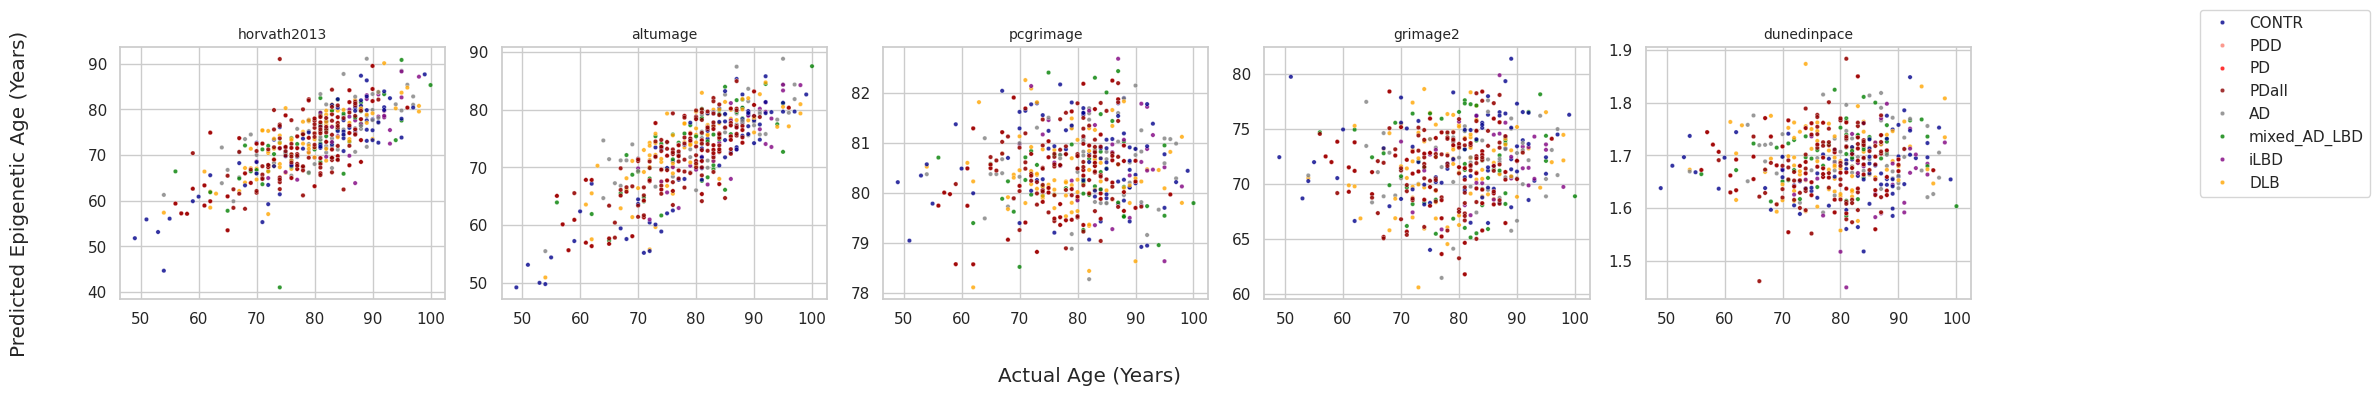

In [89]:

# Set plot style
sns.set_theme(style="whitegrid")

legend_handles = None # Initialize variables to store legend info
legend_labels = None


ncols = 5
num_clocks = len(clock_cols)
nrows = math.ceil(num_clocks / ncols)
# --- Create Subplots Grid ---
fig_scatter, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 4), sharex=False, sharey=False) # Use sharex=False now
axes_flat = axes.flatten()

for i, clock in enumerate(clock_cols):
    ax = axes_flat[i]

    # Determine if legend should be created on this plot (only the first one)
    create_legend = (i == 0)

    sns.scatterplot(
        data=data_clock,
        x=actual_age_col,
        y=clock,
        hue=condition_col,
        hue_order=label_order,
        palette=condition_color,
        ax=ax,
        s=10,
        alpha=0.8,
        legend='full' if create_legend else False # Generate full legend only for the first plot
    )

    # Capture handles and labels from the first plot, then remove its legend
    if create_legend:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    ax.set_title(f'{clock}', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Add common axis labels to the figure
fig_scatter.supxlabel('Actual Age (Years)', y=0.02)
fig_scatter.supylabel('Predicted Epigenetic Age (Years)', x=0.02)

# Hide unused subplots
for j in range(num_clocks, nrows * ncols):
    axes_flat[j].set_visible(False)

if legend_handles and legend_labels:
    # Adjust title string and position as needed
    fig_scatter.legend(
        legend_handles,
        legend_labels,
        bbox_to_anchor=(0.99, 0.98), # Position outside top-right
        loc='upper left',           # Anchor point of the legend box
        ncol=1                      # Number of columns in legend
     )


# Adjust layout AFTER adding legend
plt.tight_layout(rect=[0.03, 0.03, 0.90, 0.96]) # Leave space on right for legend (adjust rect right boundary)
plt.show()


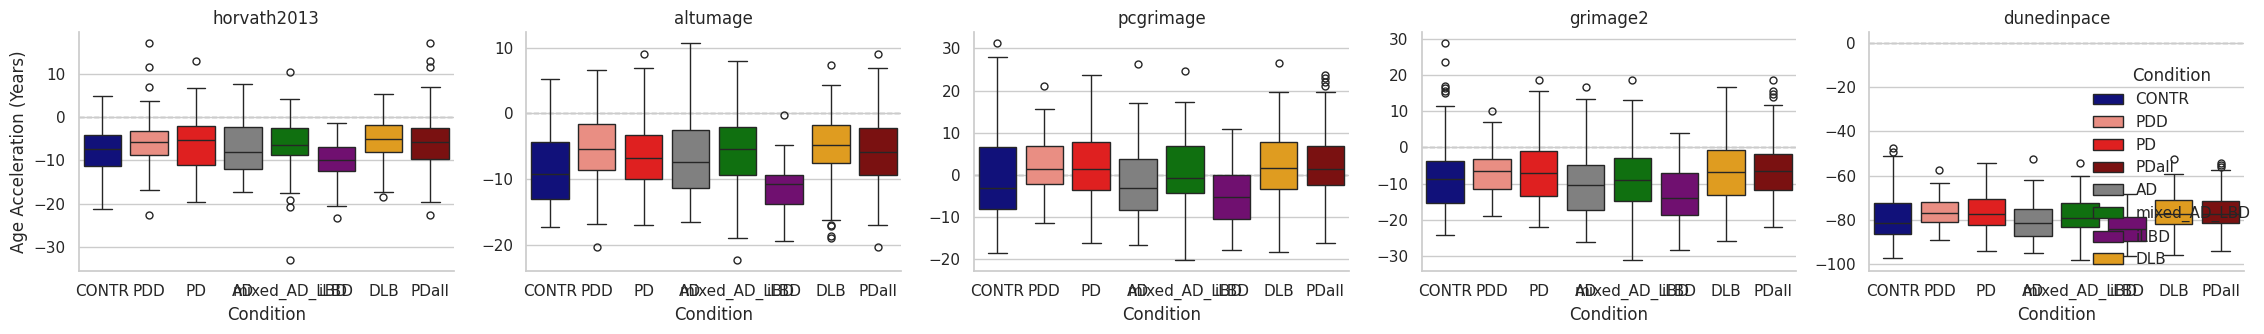

In [90]:
# Age discrepancy

accel_cols = []
for clock in clock_cols:
    accel_col_name = f'{clock}_Accel'
    data_clock[accel_col_name] = data_clock[clock] - data_clock[actual_age_col]
    accel_cols.append(accel_col_name)



df_long = pd.melt(
    data_clock.reset_index(),
    id_vars=['index', actual_age_col, condition_col, donor_col, 'Gender'] + clock_cols,
    value_vars=accel_cols,
    var_name='ClockAccelerationType',
    value_name='AgeAcceleration'
)
df_long['ClockAccelerationType'] = df_long['ClockAccelerationType'].str.replace('_Accel', '')


col_wrap_num = 5 
g = sns.catplot(
    data=df_long,
    x=condition_col, 
    y='AgeAcceleration',
    # hue=condition_col, 
    hue=condition_col,  
    hue_order=label_order,
    palette=condition_color,
    col='ClockAccelerationType', 
    col_wrap=col_wrap_num,
    kind='box',           
    height=3.5, aspect=1.2,
    legend=True,
    legend_out=True, 
    sharex=True,         
    sharey=False          
)


g.map_dataframe(lambda data, color: plt.axhline(0, color='grey', linestyle='--', lw=1, zorder=0)) # Draw line behind boxes
g.set_axis_labels(f"{condition_col}", "Age Acceleration (Years)")
g.set_titles("{col_name}") # Set facet titles to clock name
g.fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()



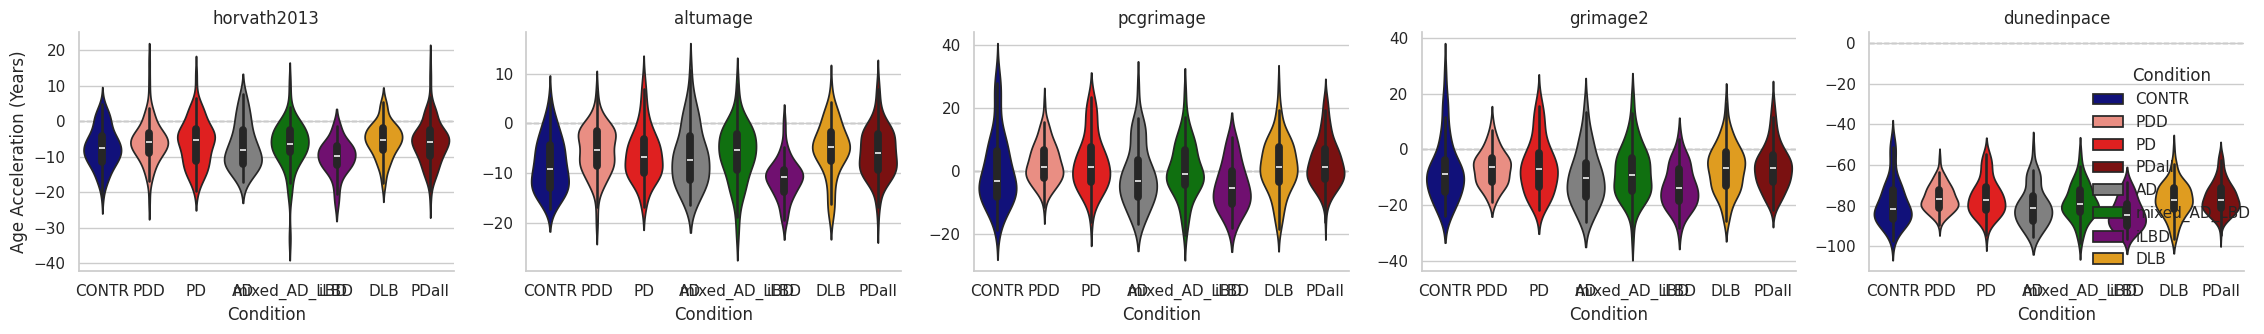

In [91]:
# Age discrepancy


col_wrap_num = 5 
g = sns.catplot(
    data=df_long,
    x=condition_col, 
    y='AgeAcceleration',
    # hue=condition_col, 
    hue=condition_col,  
    hue_order=label_order,
    palette=condition_color,
    col='ClockAccelerationType',
    col_wrap=col_wrap_num,
    kind='violin',           
    height=3.5, aspect=1.2,
    legend=True,
    legend_out=True, 
    sharex=True,         
    sharey=False          
)

g.map_dataframe(lambda data, color: plt.axhline(0, color='grey', linestyle='--', lw=1, zorder=0)) 
g.set_axis_labels(f"{condition_col}", "Age Acceleration (Years)")
g.set_titles("{col_name}") 
g.fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()


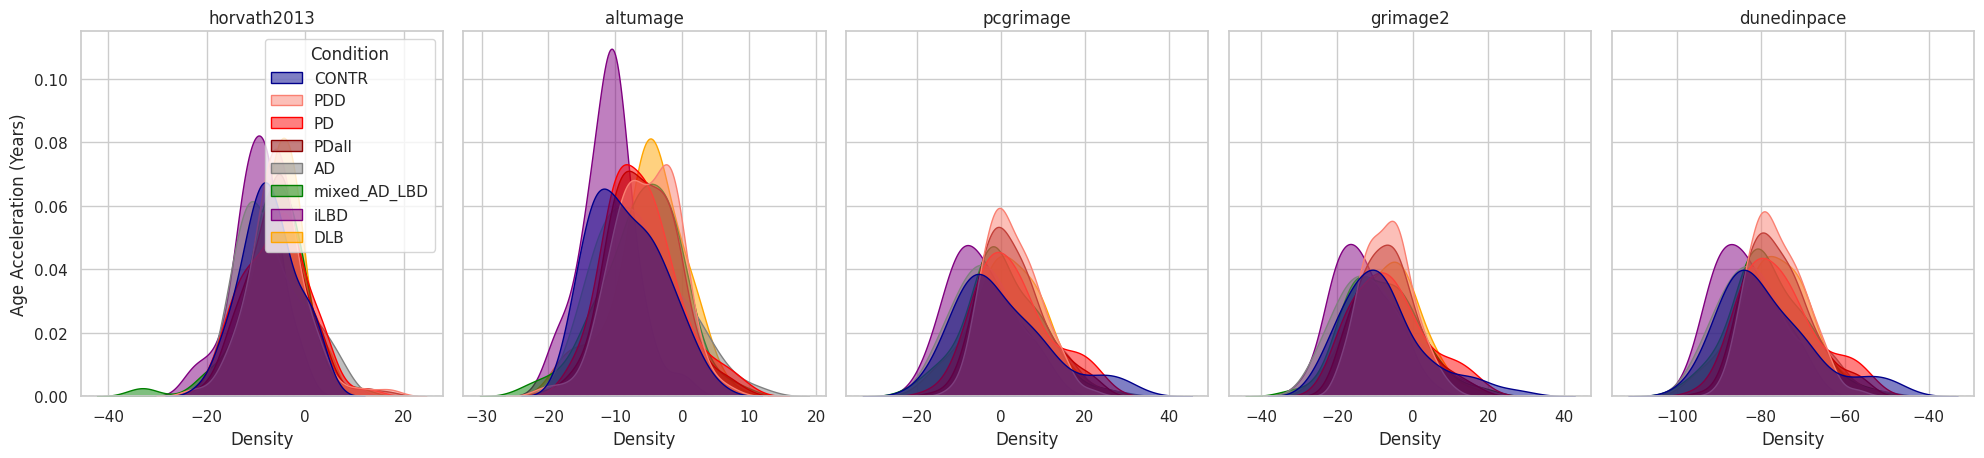

In [92]:
ncols = 5
num_clocks = len(clock_cols)
# Ensure nrows is at least 1
nrows = math.ceil(num_clocks / ncols) if num_clocks > 0 else 1
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 5), sharex=False, sharey=True)
axes_flat = axes.flatten()

# --- Loop and create each plot ---
for i, clock in enumerate(clock_cols):
    ax = axes_flat[i]
    
    # Use kdeplot with hue='Condition' to create the 4 separate curves
    sns.kdeplot(
        data=df_long[(df_long['ClockAccelerationType'] == clock)],
        x='AgeAcceleration',    
        hue=condition_col,      
        palette=condition_color,
        hue_order=label_order,
        fill=True,
        alpha=0.5,
        common_norm=False,
        ax=ax,
        legend=(i == 0) 
    )
    
    ax.axhline(0, color='grey', linestyle='--', lw=1)
    ax.set_title(clock)
    ax.set_xlabel("Density") 
    
    if i > 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Age Acceleration (Years)")

for j in range(num_clocks, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust for suptitle
plt.show()

## Altumage

In [93]:
clock = "altumage"
df_altumage = df_long[df_long['ClockAccelerationType'] == clock].copy()

In [94]:
# Define the control group and identify all disease groups
control_group = 'CONTR'
all_conditions = data_clock[condition_col].unique()
disease_groups = [c for c in all_conditions if c != control_group]

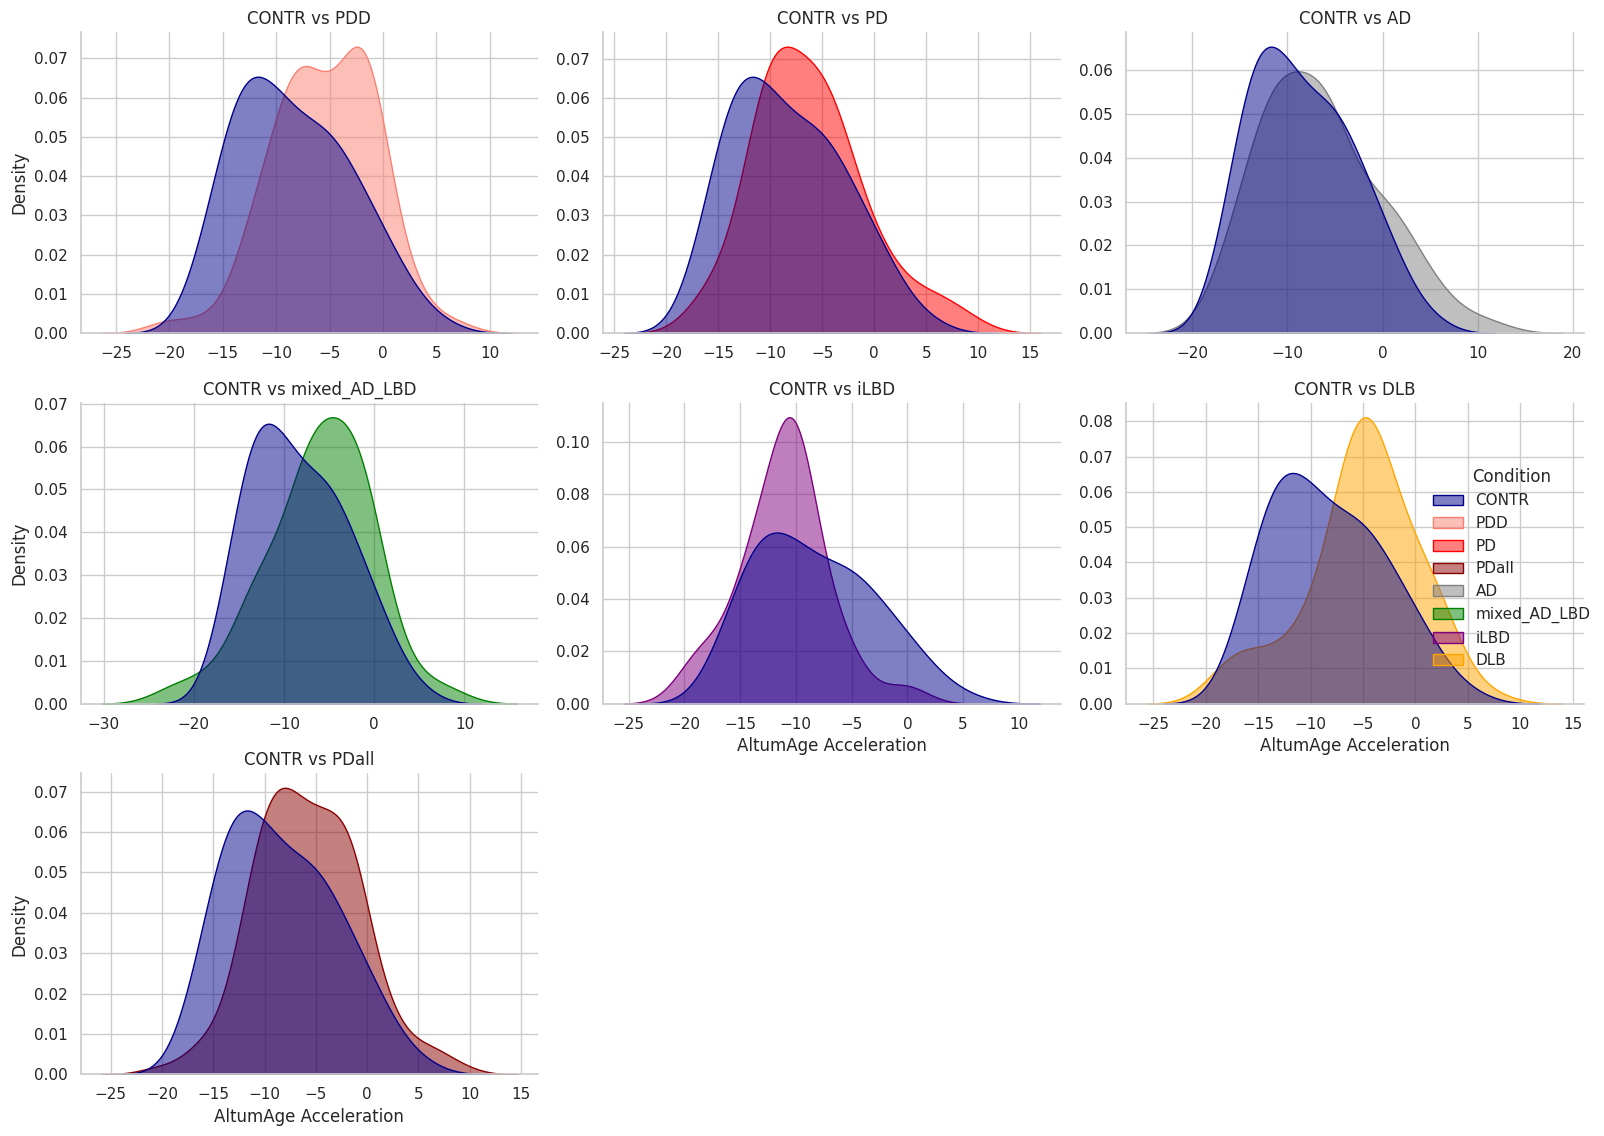

In [95]:
plot_data_list = []
control_df = df_altumage[df_altumage[condition_col] == control_group]
for disease in disease_groups:
    disease_df = df_altumage[df_altumage[condition_col] == disease]
    # For each disease, create a temporary df with that disease and the controls
    # Add a 'Comparison' column for faceting
    temp_df = pd.concat([control_df, disease_df])
    temp_df['Comparison'] = f'{control_group} vs {disease}'
    plot_data_list.append(temp_df)
df_for_plotting = pd.concat(plot_data_list, ignore_index=True)

# Create the faceted density plot
g = sns.displot(
    data=df_for_plotting,
    x='AgeAcceleration',
    hue=condition_col,
    hue_order=label_order,
    palette=condition_color,
    col='Comparison',          
    col_wrap=3,                
    kind='kde',
    fill=True,
    alpha=0.5,
    common_norm=False,
    height=4, aspect=1.2,
    facet_kws={'sharey': False, 'sharex': False} 
)

g.set_axis_labels("AltumAge Acceleration", "Density")
g.set_titles("{col_name}")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [96]:
# Identify groups and prepare data
control_data = df_altumage[df_altumage[condition_col] == 'CONTR']['AgeAcceleration'].dropna()
disease_groups = [c for c in df_altumage[condition_col].unique() if c != 'CONTR']
test_results = []

# Loop through each disease group to compare against the control group
for disease in disease_groups:
    disease_data = df_altumage[df_altumage[condition_col] == disease]['AgeAcceleration'].dropna()
    
    # Skip if a group has too few samples for a meaningful test
    if len(disease_data) < 3 or len(control_data) < 3:
        continue

    # Check normality for both groups
    shapiro_ctrl_p = stats.shapiro(control_data).pvalue
    shapiro_disease_p = stats.shapiro(disease_data).pvalue

    # Decide which test to use and calculate p-value
    if shapiro_ctrl_p > 0.05 and shapiro_disease_p > 0.05:
        # Data appears normal -> Use t-test
        test_used = "T-test"
        # Check for equal variance to use the correct t-test type
        levene_p = stats.levene(control_data, disease_data).pvalue
        equal_variances = levene_p > 0.05
        statistic, p_value = stats.ttest_ind(control_data, disease_data, equal_var=equal_variances)
    else:
        # Data does not appear normal -> Use Mann-Whitney U
        test_used = "Mann-Whitney U"
        statistic, p_value = stats.mannwhitneyu(control_data, disease_data, alternative='two-sided')
    
    # Store the result
    test_results.append({
        'Comparison': f"Control vs. {disease}",
        'Test_Used': test_used,
        'Statistic': statistic,
        'P_Value': p_value
    })

# Create a DataFrame and correct for multiple comparisons
results_df = pd.DataFrame(test_results)

is_significant, p_values_corrected, _, _ = multipletests(
    results_df['P_Value'], 
    alpha=0.05, 
    method='fdr_bh'
)

results_df['p.adj'] = p_values_corrected
results_df['Is_Significant_After_Correction'] = is_significant

# Display the final summary table
results_df_sorted = results_df.sort_values(by='p.adj')
print(results_df_sorted)

                 Comparison       Test_Used    Statistic   P_Value     p.adj  \
5           Control vs. DLB  Mann-Whitney U  2084.000000  0.000226  0.001584   
0           Control vs. PDD          T-test    -3.474505  0.000667  0.001682   
6         Control vs. PDall          T-test    -3.429479  0.000721  0.001682   
4          Control vs. iLBD          T-test     2.946854  0.004279  0.007488   
1            Control vs. PD          T-test    -2.388809  0.018199  0.025478   
3  Control vs. mixed_AD_LBD          T-test    -2.201987  0.029501  0.034418   
2            Control vs. AD          T-test    -1.774623  0.078265  0.078265   

   Is_Significant_After_Correction  
5                             True  
0                             True  
6                             True  
4                             True  
1                             True  
3                             True  
2                            False  


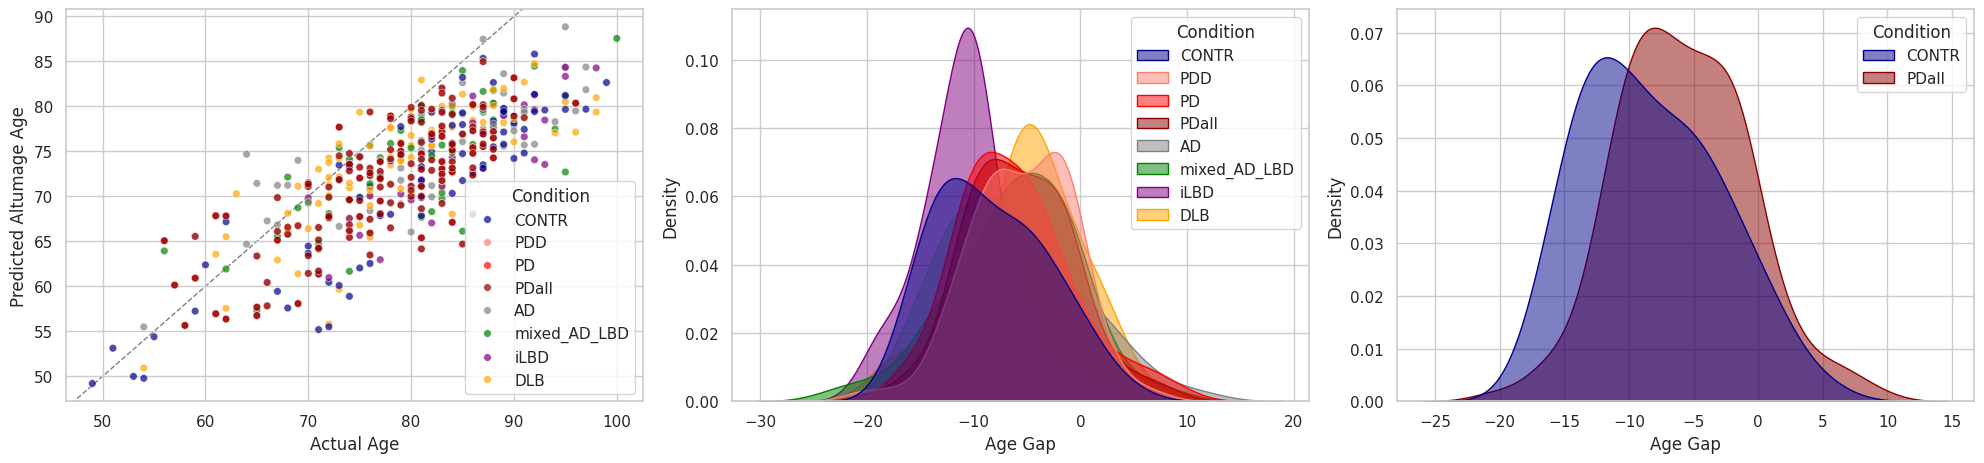

In [97]:


clock = 'altumage'
conditions_to_keep = ['CONTR', "PDall"]


# Create Figure and Axes
fig = plt.figure(figsize=(20, 5)) # 2 rows, 3 columns

# Define the grid structure with width ratios
# Make the middle column (index 1) narrower, e.g., 70% of the others
gs = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 1], height_ratios=[1])

# Create axes individually using the grid spec
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1]) 
ax02 = fig.add_subplot(gs[0, 2])



# Row 1, Col 1: Scatter Plot (Predicted vs Actual)
ax = ax00
sns.scatterplot(
    data=data_clock,
    x=actual_age_col,
    y=clock,
    hue=condition_col,
    hue_order=label_order,
    palette=condition_color,
    s=30, alpha=0.7,
    ax=ax,
    legend=True
)


x_lim = ax.get_xlim(); y_lim = ax.get_ylim()
plot_min = min(x_lim[0], y_lim[0]); plot_max = max(x_lim[1], y_lim[1])
ax.plot([plot_min, plot_max], [plot_min, plot_max], color='grey', linestyle='--', lw=1, zorder=0)
ax.set_xlim(x_lim); ax.set_ylim(y_lim)
ax.set_xlabel("Actual Age")
ax.set_ylabel(f"Predicted {clock.title()} Age")

# Row 1, Col 2
ax = ax01
sns.kdeplot(
    data=df_long[(df_long['ClockAccelerationType'] == clock)],
    x='AgeAcceleration',    
    hue=condition_col,     
    hue_order=label_order,
    palette=condition_color,
    fill=True,
    alpha=0.5,
    common_norm=False,
    ax=ax,
)

ax.axhline(0, color='grey', linestyle='--', lw=1)
ax.set_xlabel("Age Gap") 


# Row 1, Col 3
ax = ax02
sns.kdeplot(
    data=df_long[(df_long['ClockAccelerationType'] == clock) &
    (df_long[condition_col].isin(conditions_to_keep))],
    x='AgeAcceleration',    
    hue=condition_col,      
    palette=condition_color,
    fill=True,
    alpha=0.5,
    common_norm=False,
    ax=ax,
)

ax.axhline(0, color='grey', linestyle='--', lw=1)
ax.set_xlabel("Age Gap") 




plt.tight_layout(rect=[0, 0, 1, 0.96]) 
filename_fig = ('FrontalCortex_AltumAge_clock.svg')
plt.savefig(os.path.join(figureDir, filename_fig))
filename_fig = ('FrontalCortex_AltumAge_clock.pdf')
plt.savefig(os.path.join(figureDir, filename_fig))
plt.show()
